## Les imports 

In [7]:

import numpy as np

from MacsumAggregationLearning import *
from typing import Tuple

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Géneration des données

In [2]:

N = 3
# C'est le vrai noyau que l'on va essayer de retrouver
phi_true = np.random.uniform(low=-1.0, high=1.0, size=N) 
macsum_true = Macsum(N,phi_true)
print(f"True Kernel : {phi_true}")

True Kernel : [-0.07109603  0.56339352  0.6599143 ]


In [3]:
def generate_data_for_macsum(
    macsum, 
    n_samples: int, 
    noise_level: float = 0.01,
    borne: int = 50.0
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Génère un jeu de données (X, Y) qui suit la logique du modèle Macsum.
    CORRIGÉE : y_inside est maintenant bien généré à l'intérieur de l'intervalle.
    """
    n = len(phi_true)
    n_samples= int(n_samples * 1.1)
    
    X  = np.random.uniform(low=-borne, high=borne, size=(n_samples,n))
    Y = np.zeros(n_samples)

    for i in range(n_samples):
        x = X[i]

        y_lower_true, y_upper_true = macsum.prediction(x)
        
        
        y_inside = (y_upper_true + y_lower_true)/2
        
        # 3. Ajouter un peu de bruit de mesure (gaussien) pour plus de réalisme.
        interval_spread = y_upper_true - y_lower_true
        if interval_spread < 1e-6:
             interval_spread = 1.0 # Éviter la division par zéro
             
        noise = np.random.randn() * noise_level * interval_spread
        
        Y[i] = y_inside + noise

    eval_index = int(n_samples*0.1)
    return X[eval_index:], Y[eval_index:], X[:eval_index], Y[:eval_index]

In [4]:
X,Y,X_eval,Y_eval = generate_data_for_macsum( macsum_true,1000,borne=50)
print(X_eval,Y_eval)

[[-4.70783435e+01 -3.22167116e+01  4.06436060e+01]
 [-3.66710311e+01  3.68805964e+01 -1.14003378e+01]
 [-1.57651198e+01 -1.36448058e+01 -3.04652950e+00]
 [ 1.92964977e+01 -1.14057643e+01 -1.96383225e+01]
 [ 2.05564161e+01 -3.77800647e+01  3.00009183e+01]
 [-2.17015371e+01 -2.39205479e+01  3.56607887e+01]
 [ 7.84305342e+00  3.26303532e+01 -3.53032942e+01]
 [-2.64208783e+01 -1.08557254e+00  3.56851969e+01]
 [ 4.18567071e+00 -2.90839604e-01  4.97365771e+01]
 [-1.46141419e+00 -1.74448319e+01 -3.98381359e+01]
 [ 6.94384856e+00  4.27706466e+01 -4.11633328e+01]
 [-4.29907775e+01  1.20329775e+01  2.68042505e+01]
 [ 3.61501005e+01 -2.57649075e+01  2.37250161e+01]
 [-3.68680728e+01  2.88887800e+01  1.67984482e+01]
 [-4.73786113e+01  3.23559662e+00  3.82016395e+01]
 [-2.18580976e+01 -1.07283747e+00  2.98092179e+01]
 [ 1.97243480e+00  1.09845274e+01 -2.73010272e+01]
 [-4.74779644e+01 -1.62620410e+00 -3.14045836e+01]
 [-3.67997568e+01  4.87394421e+00 -3.57424864e+01]
 [ 3.67115920e+01 -1.45898544e+

## Entrainement

### Moindres carrés pour un noyau initial

In [6]:
initial_phi, _, _, _ = np.linalg.lstsq(X, Y, rcond=None)
print(initial_phi)

[ 0.01281984 -0.20292674  0.10540628]


In [7]:
macsum = Macsum(N,initial_phi)
evaluate_model(X,Y,macsum)

{'containment_rate': 0.25353535353535356,
 'avg_distance_to_interval': 2.749803850570376,
 'avg_loss': 63.336818834466,
 'avg_interval_spread': 3.808941752756752}

In [ ]:
macsum = Macsum(N)
macsum.fit(X,Y,X_eval,Y_eval,n_iteration=20000,alpha=1e-6,epsilon=1e-5)

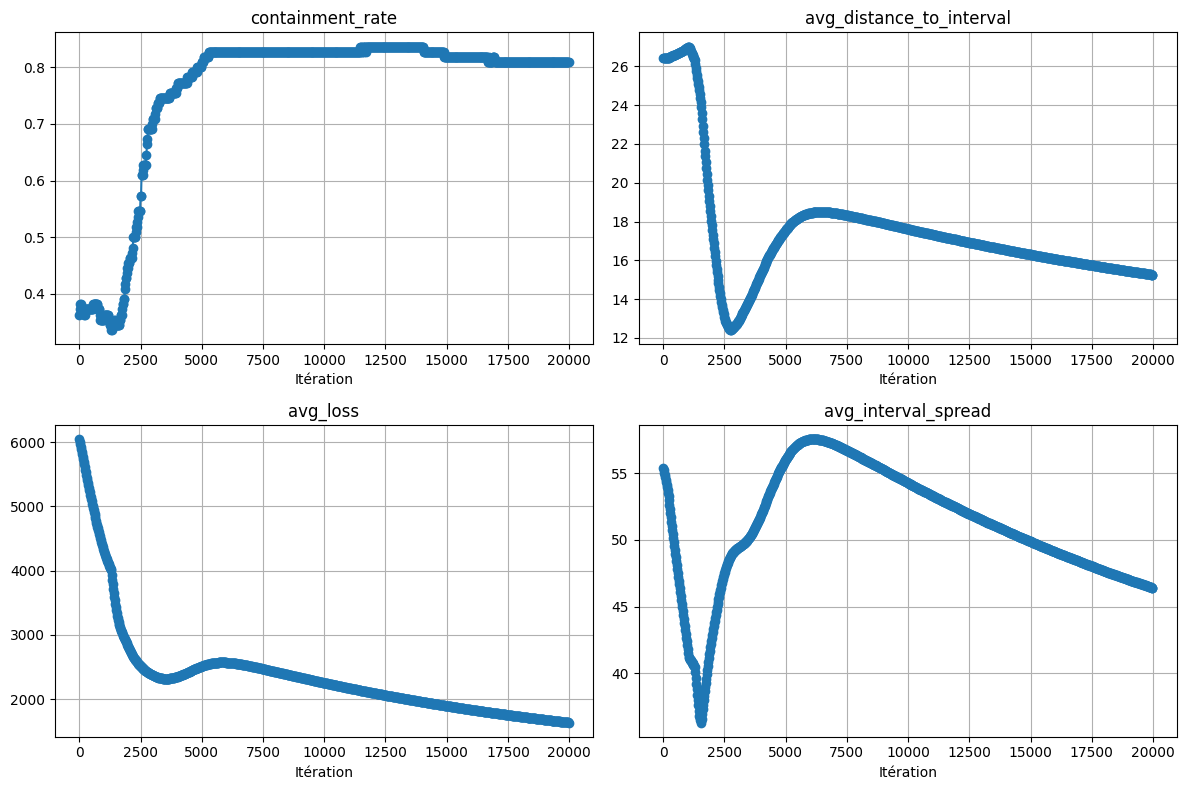

{'containment_rate': 0.8535353535353535,
 'avg_distance_to_interval': 15.990523108731487,
 'avg_loss': 1666.2319976847755,
 'avg_interval_spread': 48.10444384780719}

In [74]:
plot_metrics(macsum.history)
evaluate_model(X,Y,macsum)

In [ ]:
macsum =  Macsum(N)
macsum.fit_adam(X,Y,X_eval,Y_eval,n_epochs=2000,learning_rate=1e-3,epsilon_conv=5e-6,batch_size=64)

Début de l'entraînement avec l'optimiseur Adam...


Entraînement Adam: 100%|██████████| 3000/3000 [01:59<00:00, 25.13it/s]

Entraînement terminé (nombre maximum d'époques atteint).


array([0.11264173, 0.65395643, 0.65446279])

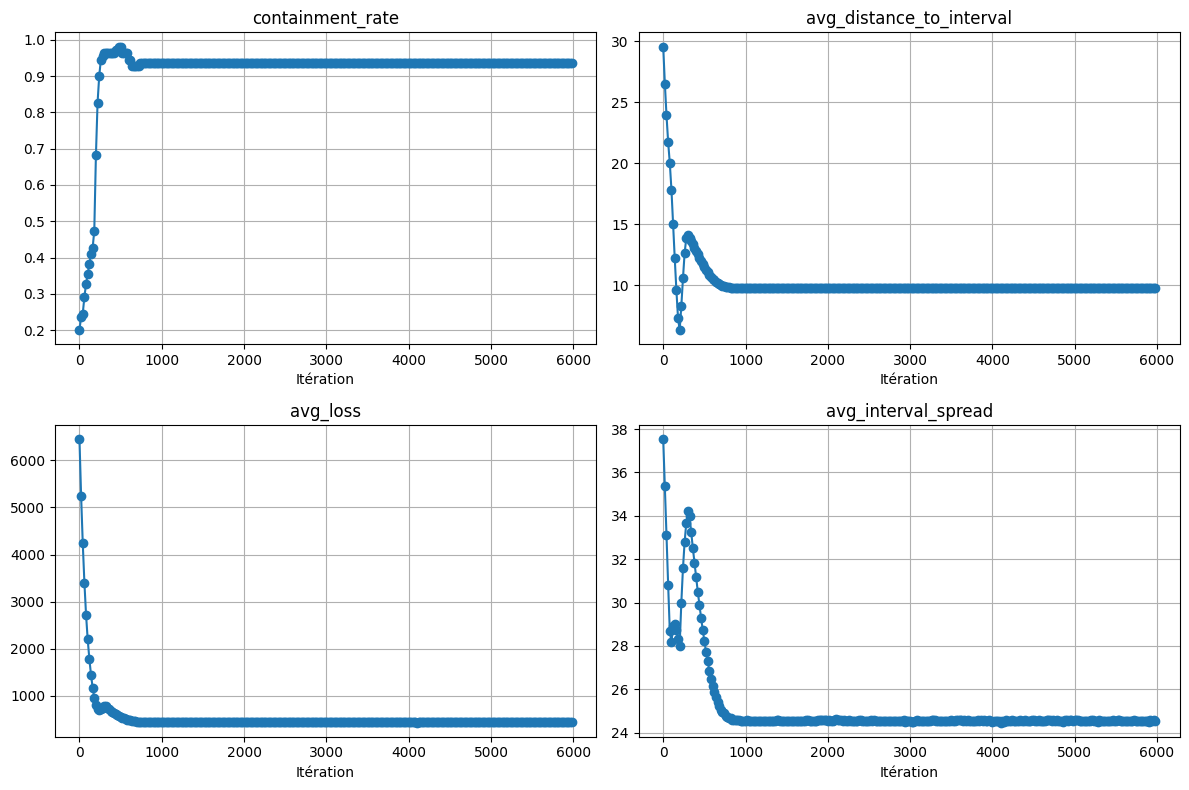

{'containment_rate': 0.9525252525252526,
 'avg_distance_to_interval': 9.553078499650669,
 'avg_loss': 414.1628563439284,
 'avg_interval_spread': 24.205252524226747}

In [15]:
plot_metrics(macsum.history)
evaluate_model(X,Y,macsum)

In [ ]:
macsum = Macsum(N)
#macsum.fit_adam_clipping(X,Y,X_eval,Y_eval,n_epochs=5000,learning_rate=1e-4,batch_size=128)

Début de l'entraînement avec Adam et Gradient Clipping...


Entraînement Adam: 100%|██████████| 5000/5000 [03:41<00:00, 22.59it/s]


array([-0.66226723,  0.36321435, -0.66228911])

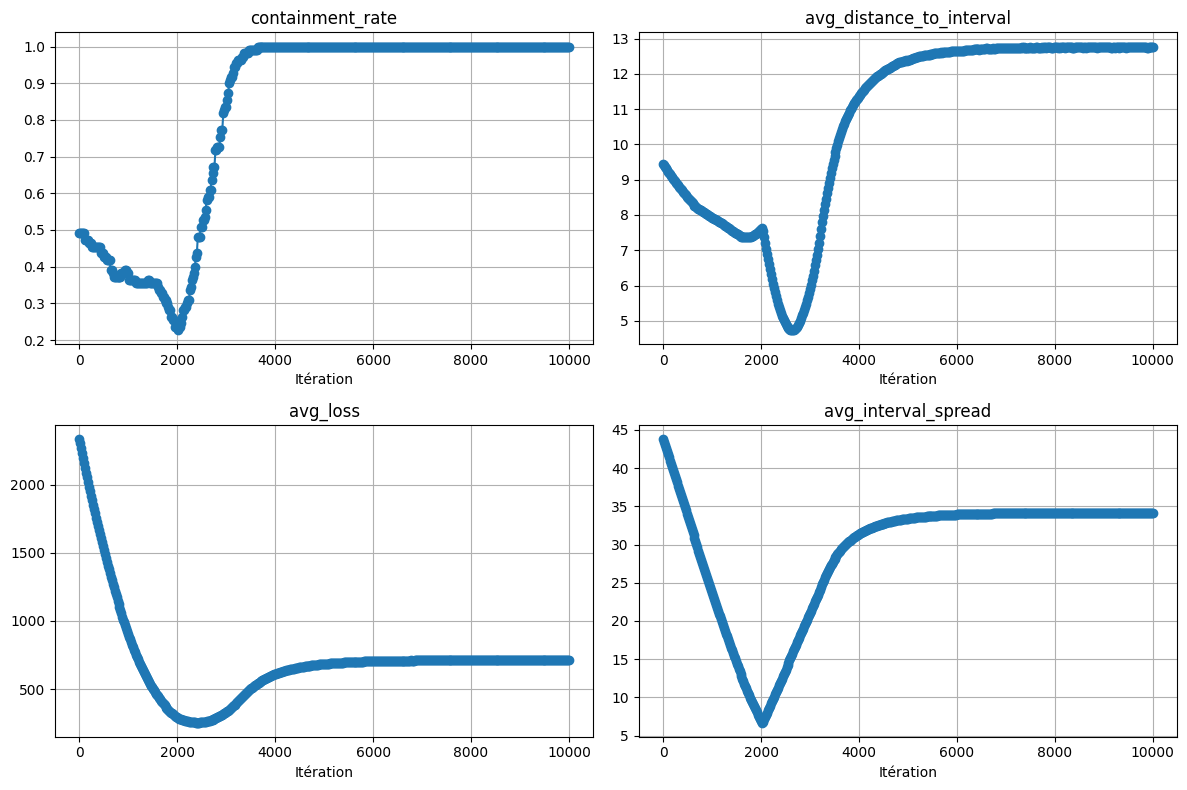

{'containment_rate': 0.998989898989899,
 'avg_distance_to_interval': 12.261794558487907,
 'avg_loss': 695.6214548200522,
 'avg_interval_spread': 32.95590120800579}

In [66]:
plot_metrics(macsum.history)
evaluate_model(X,Y,macsum)